# IRSA cloud access introduction

This is the introductory tutorial demonstrating basic python access to the IRSA-curated images and catalogs available in AWS S3 cloud storage buckets.

Learning Goals:

- Find datasets and connection information.
- Browse buckets.
- Find an image and retrieve a cutout.
- Navigate a catalog and perform a basic query.

## 1. Cloud basics

### 1.1 Terminology

AWS S3 is an [object store](https://en.wikipedia.org/wiki/Object_storage) where the fundamental entities are "buckets" and "objects".
Buckets are containers for objects, and objects are blobs of data.
Users may be more familiar with [filesystem](https://en.wikipedia.org/wiki/File_system) "files" and "directories".
Files are analogous to objects, and the terms are often used interchangeably.
While there is no directory-like structure in S3 itself, various layers on top of S3 have implemented functionality to mimic it.
As a result, users can generally interact using familiar filesystem logic, but may notice subtle differences.

The following S3 terms are also used in this notebook:

- Key: Unique ID for an object, relative to the bucket. Analogous to the full path to a file.
- Prefix: String of characters at the beginning of the object key. Analogous to the full path to a directory.

### 1.2 General access

Most of the common python methods used to read images and catalogs from a local disk can also be pointed at cloud storage buckets.
This includes methods like Astropy `fits.open` and Pandas `read_parquet`.
The cloud connection is handled by a separate library, usually [s3fs](https://s3fs.readthedocs.io), [fsspec](https://filesystem-spec.readthedocs.io), or [pyarrow.fs](https://arrow.apache.org/docs/python/api/filesystems.html).

The IRSA buckets are public and access is free.
Credentials are not required.
Anonymous connections can be made, often by setting a keyword argument like `anon=True`.

## 2. Find datasets and connection information

A listing of the available datasets is maintained on [IRSA's Cloud Access](https://irsa.ipac.caltech.edu/cloud_access/) page.
It can be used to substitute values for the following variables, which are used throughout this notebook and identified by all caps:

| Cloud Access Variable | Definition |
| --- | --- |
| `BUCKET_NAME` | AWS S3 bucket name. |
| `BUCKET_REGION` | AWS region the bucket is in. |
| `IMAGES_PREFIX`| S3 prefix to the base of an image set. |
| `CATALOG_PREFIX` | S3 prefix to the base of a catalog. |
| `PARQUET_NAME` | Path to the base of the catalog's Parquet dataset, relative to the prefix. |

## 3. Imports

The following libraries will be used:

- astropy: perform image cutouts
- hpgeom: map sky location to catalog partition
- matplotlib: view results
- pandas: query Parquet datasets
- pyarrow: work with Parquet datasets
- pyvo: locate images in the cloud (pyvo>=1.5 required)
- s3fs: browse buckets

Libraries are imported at the top of each section where used.
This cell will install them if needed:

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install astropy hpgeom pandas pyarrow pyvo>=1.5 s3fs matplotlib astroquery

## 4. Browse buckets

Generally, it is not necessary to look through the buckets.
The Cloud Access page is the best way to understand what is available.
However, browsing buckets can sometimes be useful.

The [s3fs](https://s3fs.readthedocs.io) library offers a filesystem-like experience and is demonstrated below.
Beware that these datasets can contain millions of files or more --
if calls are taking a long time to return, try narrowing the search by adding additional levels to the prefix.

Users who want to interact with the buckets and objects more directly may instead prefer the [AWS Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html) library.

In [2]:
import s3fs

In [3]:
# create an S3 client
s3 = s3fs.S3FileSystem(anon=True)

`ls` the root directory of the Spitzer SEIP Super Mosaics image set:

In [4]:
BUCKET_NAME = "nasa-irsa-spitzer"
IMAGES_PREFIX = "spitzer/seip/seip_science/images"

s3.ls(f"{BUCKET_NAME}/{IMAGES_PREFIX}/")

['nasa-irsa-spitzer/spitzer/seip/seip_science/images/2',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/3',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/5',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/6',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/7']

Use wildcard (glob) matching to find mosaics.
This can be slow if looking through a large number of files, so we'll add a few levels to the base prefix to reduce the number of files in the search.
The additional levels can be found using `ls` recursively or constructed using information on the Cloud Access page.

In [5]:
sub_prefix = "4/0019/40019821/9"
glob_pattern = "**/*.mosaic.fits"

s3.glob(f"{BUCKET_NAME}/{IMAGES_PREFIX}/{sub_prefix}/{glob_pattern}")

['nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-19/40019821.40019821-19.MIPS.1.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9-short.IRAC.1.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9-short.IRAC.2.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9-short.IRAC.3.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9-short.IRAC.4.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9.IRAC.1.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9.IRAC.2.mosaic.fits',
 'nasa-irsa-spitzer/spitzer/seip/seip_science/images/4/0019/40019821/9/40019821-9/40019821.40019821-9.IRAC.3.mosa

## 5. Find an image and retrieve a cutout

A basic image cutout using [Astropy](https://docs.astropy.org/en/stable/) is demonstrated in section 5.2.
It requires a bucket name and image key.
Section 5.1 demonstrates how to query IRSA for this information using [PyVO](https://pyvo.readthedocs.io/en/latest/index.html) and a coordinate search.

Note: There may be a delay between the time when a new dataset is made available in S3 and when IRSA's image services are able to return the new cloud access information.
In this case, the IRSA URL that is returned by the service can be mapped to the cloud information.
This is explained further on the Cloud Access page, and also demonstrated in section 5.1 below.

In [6]:
import astropy.io
import json
import pyvo
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from matplotlib import pyplot as plt

### 5.1 Find an image using PyVO and a coordinate search

In [7]:
coords = SkyCoord("150.01d 2.2d", frame="icrs")
size = 0.01 * u.deg

For the full list of datasets that can be used with the `collection` parameter in the SIA search below, uncomment the next cell.
Note that only some of these are currently available in cloud storage.
To request that additional datasets be made available in cloud storage, please contact IRSA's [Help Desk](https://irsa.ipac.caltech.edu/docs/help_desk.html).

In [8]:
# from astroquery.ipac.irsa import Irsa

# Irsa.list_collections()


Use PyVO to execute a search for Spitzer SEIP Super Mosaics and find cloud access information:

In [9]:
irsa_SIA = pyvo.dal.SIA2Service("https://irsa.ipac.caltech.edu/SIA")
seip_results = irsa_SIA.search((coords, size), collection="spitzer_seip")

# view cloud access info for the first few files overlapping the search area
seip_results["cloud_access"][:5]

masked_array(data=['{"aws": {"bucket_name": "nasa-irsa-spitzer", "key":"spitzer/seip/seip_science/images/6/0095/60095931/4/60095931-14/60095931.60095931-14.IRAC.4.brightmask.fits", "region": "us-west-2"}}',
                   '{"aws": {"bucket_name": "nasa-irsa-spitzer", "key":"spitzer/seip/seip_science/images/6/0095/60095931/4/60095931-14/60095931.60095931-14.IRAC.4.extmask.fits", "region": "us-west-2"}}',
                   '{"aws": {"bucket_name": "nasa-irsa-spitzer", "key":"spitzer/seip/seip_science/images/6/0095/60095931/4/60095931-14/60095931.60095931-14.IRAC.4.unc.fits", "region": "us-west-2"}}',
                   '{"aws": {"bucket_name": "nasa-irsa-spitzer", "key":"spitzer/seip/seip_science/images/6/0095/60095931/4/60095931-14/60095931.60095931-14.IRAC.4.std.fits", "region": "us-west-2"}}',
                   '{"aws": {"bucket_name": "nasa-irsa-spitzer", "key":"spitzer/seip/seip_science/images/6/0095/60095931/4/60095931-14/60095931.60095931-14.IRAC.4.mosaic.fits", "region": "u

**Option 1**: Extract the cloud information from the "cloud_access" column for a single mosaic file:

In [10]:
# find the first mosaic file in the results
# use json to convert the string containing the cloud info to a dictionary
mosaics = [i for i in seip_results["cloud_access"] if ".mosaic.fits" in i]
seip_mosaic_cloud_info = json.loads(mosaics[0])

# extract
BUCKET_NAME = seip_mosaic_cloud_info["aws"]["bucket_name"]
image_key = seip_mosaic_cloud_info["aws"]["key"]

**Option 2**: Construct the cloud information for a single mosaic file from the IRSA URL (useful if you know the dataset is in S3, but results in the "cloud_access" column were empty):

In [11]:
BUCKET_NAME = "nasa-irsa-spitzer"
IMAGES_PREFIX = "spitzer/seip/seip_science/images"

# find the first mosaic URL in the results
image_url = [url for url in seip_results["access_url"] if ".mosaic.fits" in url][0]

# construct the key by replacing the first part of the URL with the IMAGES_PREFIX
# split the URL at the data product ID, the final level of the prefix
data_product_id = IMAGES_PREFIX.split("/")[-1]
key_suffix = image_url.split(f"/{data_product_id}/")[-1]
image_key = f"{IMAGES_PREFIX}/{key_suffix}"

### 5.2 Retrieve a cutout using Astropy

Lazy-load data for better performance.
The relevant options are enabled by default when using `astropy.io.fits.open` with `fsspec`.
In addition, use the HDU `section` method in place of the usual `data` to avoid downloading the full data block.
(See [Obtaining subsets from cloud-hosted FITS files](https://docs.astropy.org/en/stable/io/fits/usage/cloud.html#fits-io-cloud).)

In [12]:
s3_image_path = f"s3://{BUCKET_NAME}/{image_key}"
with astropy.io.fits.open(s3_image_path, fsspec_kwargs={"anon": True}) as hdul:
    cutout = Cutout2D(hdul[0].section, position=coords, size=size, wcs=WCS(hdul[0].header))

Show the cutout:

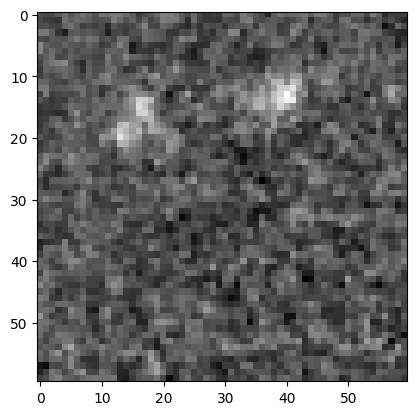

In [13]:
plt.imshow(cutout.data, cmap="gray")

## 6. Navigate a catalog and perform a basic query

The catalogs are in Apache Parquet format and partitioned spatially using HEALPix order k=5.
Parquet datasets can be queried directly using SQL-like logic by applying filters during the file reads.
For queries that have a spatial constraint, including a filter on the partitioning column can greatly improve performance.

Section 6.1 demonstrates how to view the catalog schema using [PyArrow](https://arrow.apache.org/docs/python/) to find the column names, etc. needed for constructing queries.
A basic spatial query using [Pandas](https://pandas.pydata.org/docs/) is shown in section 6.2 and includes finding the relevant partitions using [HPGeom](https://hpgeom.readthedocs.io/en/latest/).

In [14]:
import hpgeom
import pandas as pd
import pyarrow.dataset
import pyarrow.fs
from matplotlib import colors

In [15]:
BUCKET_NAME = "nasa-irsa-wise"
BUCKET_REGION = "us-west-2"

CATALOG_PREFIX = "wise/allwise/catalogs/p3as_psd/healpix_k5"
PARQUET_NAME = "wise-allwise.parquet"

parquet_root = f"{BUCKET_NAME}/{CATALOG_PREFIX}/{PARQUET_NAME}"

fs = pyarrow.fs.S3FileSystem(region=BUCKET_REGION, anonymous=True)

### 6.1 View the schema using PyArrow

In [16]:
# load the schema from the "_common_metadata" file
s3_schema_path = f"{parquet_root}/_common_metadata"
schema = pyarrow.dataset.parquet_dataset(s3_schema_path, filesystem=fs).schema

# the full schema can be quite large since catalogs often have hundreds of columns
# but if you do want to look at the entire schema, uncomment the next line
# schema

Search through the column names to find the HEALPix partitioning columns:

In [17]:
[name for name in schema.names if "healpix" in name]
# the result shows that both orders k=0 and k=5 are available, but typical use cases only need k=5

['healpix_k0', 'healpix_k5']

Look at a specific column ("ext_flg" will be used below to query for likely stars):

In [18]:
# this will display basic information like name and type
schema.field("ext_flg")

pyarrow.Field<ext_flg: int64>

In [19]:
# units and descriptions are in the field's metadata attribute
schema.field("ext_flg").metadata

{b'units': b'',
 b'description': b'Extended source flag. This is an integer flag, the value of which indicates whether or not the morphology of a source is consistent with the WISE point spread function in any band, or whether the source is associated with or superimposed on a previously known extended object from the 2MASS Extended Source Catalog (XSC). The values of the ext_flg indicate the following conditions: 0 - The source shape is consistent with a point-source and the source is not associated with or superimposed on a 2MASS XSC source 1 - The profile-fit photometry goodness-of-fit, w?rchi2, is >3.0 in one or more bands. 2 - The source falls within the extrapolated isophotal footprint of a 2MASS XSC source. 3 - The profile-fit photometry goodness-of-fit, w?rchi2, is >3.0 in one or more bands, and The source falls within the extrapolated isophotal footprint of a 2MASS XSC source. 4 - The source position falls within 5" of a 2MASS XSC source. 5 - The profile-fit photometry goodnes

### 6.2 Perform a basic spatial search with Pandas

Query the AllWISE catalog for likely stars within an RA/Dec polygon.

Spatial limits roughly covering the Taurus L1495 star-forming region:

In [20]:
ra_min, ra_max, dec_min, dec_max = 62, 66, 25, 29  # deg

polygon_corners = [(ra_min, dec_min), (ra_min, dec_max), (ra_max, dec_max), (ra_max, dec_min)]
corners = list(zip(*polygon_corners))  # [(ra values), (dec values)]

Find the partitions (HEALPix pixel indexes) that overlap the polygon:

In [21]:
k = 5
polygon_pixels = hpgeom.query_polygon(
    a=corners[0], b=corners[1], nside=hpgeom.order_to_nside(k), inclusive=True
)

Query:

In [22]:
results_df = pd.read_parquet(
    parquet_root,
    filesystem=fs,
    # columns to be returned. similar to a SQL SELECT clause.
    columns=["designation", "w1mpro", "w2mpro", "w3mpro", "w4mpro", f"healpix_k{k}"],
    # row filters. similar to a SQL WHERE clause.
    # supported operators: ==, !=, <, >, <=, >=, in, not in
    # tuple conditions are joined by AND (for OR, use a list of lists)
    filters=[
        ("ext_flg", "==", 0),
        ("ra", ">", ra_min),
        ("ra", "<", ra_max),
        ("dec", ">", dec_min),
        ("dec", "<", dec_max),
        # include filter on partition column for efficiency. similar to a database index.
        (f"healpix_k{k}", "in", polygon_pixels),
    ],
)

View results on a color-color diagram:

<Axes: xlabel='W2-W3', ylabel='W1-W2'>

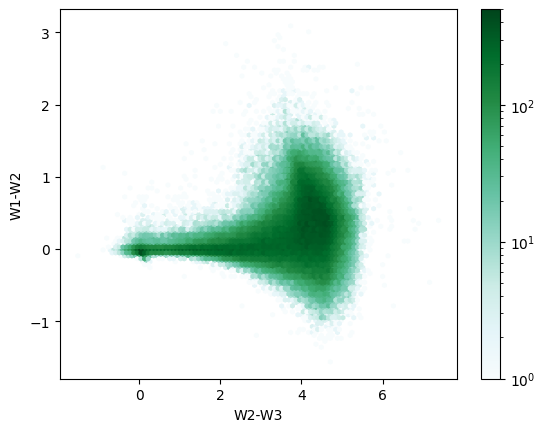

In [23]:
results_df["W1-W2"] = results_df["w1mpro"] - results_df["w2mpro"]
results_df["W2-W3"] = results_df["w2mpro"] - results_df["w3mpro"]
results_df.plot.hexbin("W2-W3", "W1-W2", norm=colors.LogNorm(vmin=1, vmax=500))

***

## About this notebook

**Author:** Troy Raen (IRSA Developer) in conjunction with Brigitta Sipőcz, Jessica Krick and the IPAC Science Platform team

**Updated:** 2024-07-29

**Contact:** [the IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions or reporting problems.